In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import seaborn as sns

# (a) Dataset Exploration

Exploring this dataset is essential due to the large number of features. We start off by describing the dataset (shape, datatypes) and finding out the number of missing values per column. Some of these categorical columns, such as koi_name, are not important to the performance of the model, which means they can be ommited. This will be further elaborated on in the preprocessing section of this notebook.

- This dataset has 30126 samples and 21 columns, with mostly numerical data.  
- The categorical columns include pl_name, koi_name, and koi_disposition.  
- The name columns are not important and will be dropped in preprocessing.  
- koi_disposition is our dependent variable, which has 3 cases (confirmed, false positive, and candidate). 
This dataset has over 30000 samples which means cross validation may be helpful but not strictly necessary.

Next, the number of missing values is calculated as a fraction, if there are too many missing values in a column, it may be beneficial to not include the column at all to avoid creating a bias towards samples without missing data. Running the code shows that there is one column, toi, which has almost 95% missing values. Looking at other datasets in this mega dataset, the toi column is likely a nomenclature based attribute, which means it is safe to drop. Once again, further steps regarding preprocessing will be discussed later in the notebook. 

We can optimize our data exploration by avoiding visualization of unnecessary columns. Anything not involving the size, structure, transit period, mainly that last section of column names, is not worth visualizing. fpp_prob and its variants are likely outputs of an external model which in our case would only serve to confuse our model, they also do not provide much meaningful information judging by the plot, therefore they will very likely be dropped in preprocessing as well. 

After plotting the graphs, most values have a distribution biased to the left side (smaller values) which is expected in the field of astrophysics. Plotting the pearson correlation of the dataset features also reveals that there is no correlation high enough to warrant removal of the feature.



In [3]:
# Dataset description

df_raw = pd.read_csv("/Users/parshvamehta/ece539-final/data/nasa-exoplanet/merged_exoplanet_ml_features.csv")
df = df_raw.copy()

n_samples, n_features = df.shape

print(f"Number of samples (rows):    {n_samples}")
print(f"Number of raw features (cols): {n_features}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
display(df.dtypes.to_frame("dtype"))

missing_frac = df.isna().mean().sort_values(ascending=False)

print("Fraction of missing values per feature (sorted):")
display(missing_frac.to_frame("missing_fraction"))

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nNumber of numeric variables:      {len(num_cols)}")
print(f"Number of categorical variables:  {len(cat_cols)}")

if cat_cols:
    print("\nCategorical variable names:")
    print(cat_cols)
else:
    print("\nNo categorical variables detected (object/category dtypes).")



Number of samples (rows):    30126
Number of raw features (cols): 21

First 5 rows:


,kepoi_name,pl_name,toi,ra,dec,koi_period,koi_duration,koi_depth,koi_prad,koi_teq,...,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,fpp_prob,fpp_prob_heb,fpp_prob_ueb,fpp_prob_beb,koi_disposition
0,K00752.01,NaN,NaN,291.93423,48.141651,9.488036,2.95750,615.8,2.26,793.0,...,35.8,5455.0,4.467,0.927,15.347,0.00068,0.000027,5.800000e-04,0.000065,CONFIRMED
1,K00752.02,NaN,NaN,291.93423,48.141651,54.418383,4.50700,874.8,2.83,443.0,...,25.8,5455.0,4.467,0.927,15.347,0.00580,0.000280,5.100000e-03,0.000056,CONFIRMED
2,K00753.01,NaN,NaN,297.00482,48.134129,19.899140,1.78220,10829.0,14.60,638.0,...,76.3,5853.0,4.544,0.868,15.436,0.93000,0.110000,8.100000e-01,0.002100,CANDIDATE
3,K00754.01,NaN,NaN,285.53461,48.285210,1.736952,2.40641,8079.2,33.46,1395.0,...,505.6,5805.0,4.564,0.791,15.597,1.00000,0.000005,5.100000e-07,0.003600,FALSE POSITIVE
4,K00755.01,Kepler-664 b,NaN,288.75488,48.226200,2.525592,1.65450,603.3,2.75,1406.0,...,40.9,6031.0,4.438,1.046,15.509,0.00100,0.000040,9.600000e-04,0.000009,CONFIRMED



Data types:


,dtype
kepoi_name,object
pl_name,object
toi,float64
ra,float64
dec,float64
koi_period,float64
koi_duration,float64
koi_depth,float64
koi_prad,float64
koi_teq,float64


Fraction of missing values per feature (sorted):


,missing_fraction
toi,0.958010
pl_name,0.279294
fpp_prob_beb,0.073823
fpp_prob_ueb,0.073823
fpp_prob_heb,0.073823
fpp_prob,0.073823
koi_depth,0.016663
koi_prad,0.016663
koi_teq,0.016663
koi_model_snr,0.016663



Number of numeric variables:      18
Number of categorical variables:  3

Categorical variable names:
['kepoi_name', 'pl_name', 'koi_disposition']


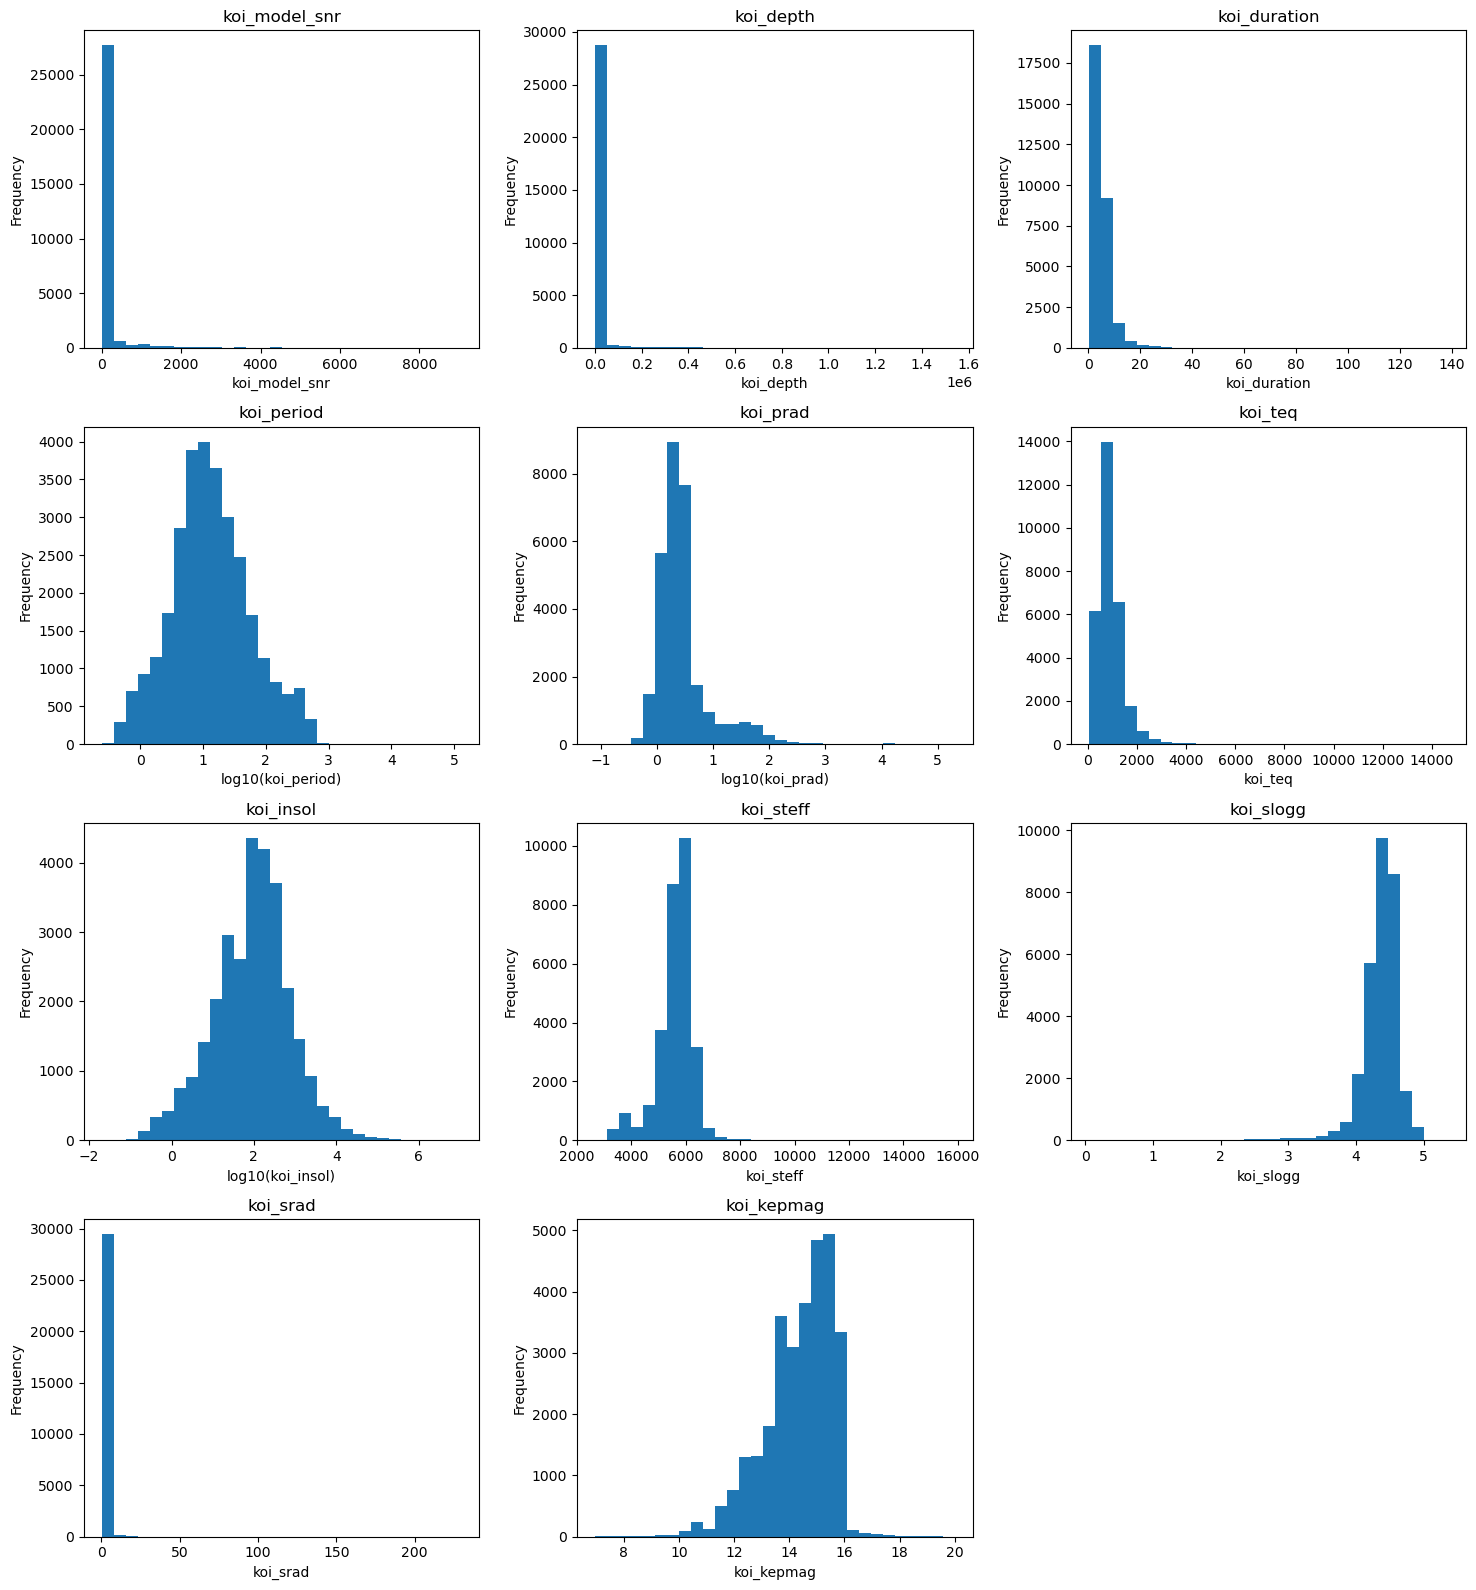

In [4]:
# Column visualization


cols = [
    "koi_model_snr",
    "koi_depth",
    "koi_duration",
    "koi_period",
    "koi_prad",
    "koi_teq",
    "koi_insol",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

log_x_cols = {
    "koi_period",
    "koi_insol",
    "koi_prad",
}
cols_to_plot = [c for c in cols if c in df_raw.columns]

n_cols = 3 
n_plots = len(cols_to_plot)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, cols_to_plot):
    data = df_raw[col].dropna()

    if col in log_x_cols:
        data = data[data > 0]
        if len(data) == 0:
            ax.text(0.5, 0.5, "No positive values", ha="center", va="center")
            ax.set_title(col + " (log scale)")
            ax.axis("off")
            continue
        ax.hist(np.log10(data), bins=30)
        ax.set_xlabel("log10(" + col + ")")
    else:
        ax.hist(data, bins=30)
        ax.set_xlabel(col)

    ax.set_title(col)
    ax.set_ylabel("Frequency")

for ax in axes[n_plots:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


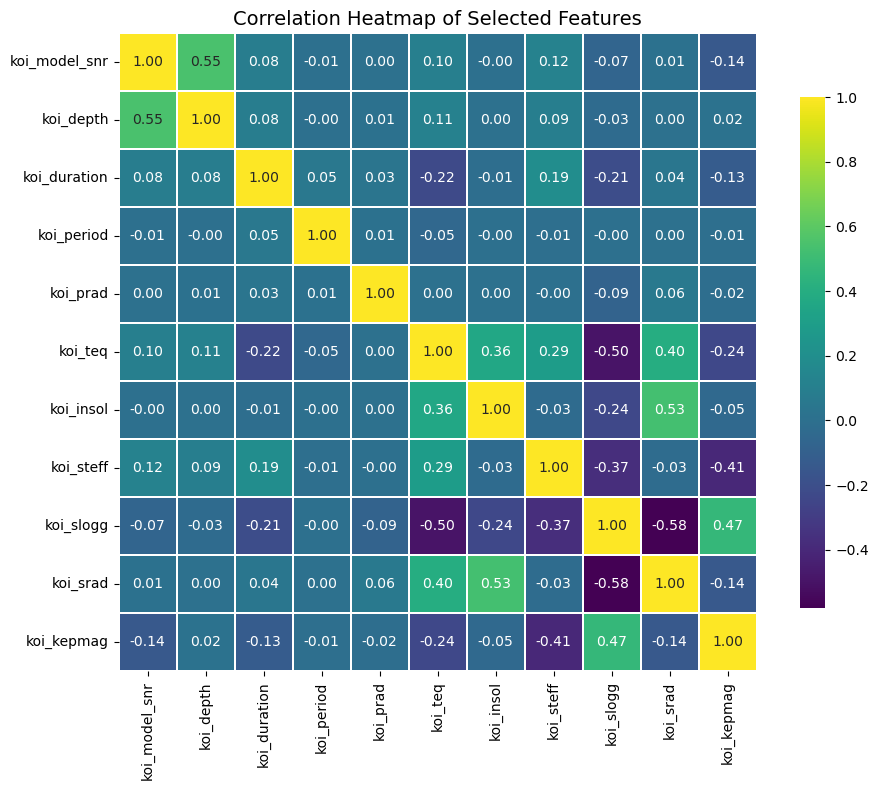

In [5]:
# Heatmap
heatmap_df = df_raw[cols].copy()
corr = heatmap_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,    
    fmt=".2f",
    cmap="viridis",
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Heatmap of Selected Features", fontsize=14)
plt.tight_layout()
plt.show()

The heatmap shows mostly uncorrelated values with a few high positive correlation and a few negative correlations. No correlation however, is strong enough to warrant the removal or combining of two features. 

# (b) Dataset Preprocessing #
Steps taken:
1. Create column for dependent label, use numerical encoding
2. Remove all identifier columns, the model does not need them
3. If there are any columns with more than 95% values missing, it is safe to remove those columns to avoid creating a bias
4. Create splits before scaling/calculating mean to avoid data leakage
5. Take all numerical columns and impute missing values with the median, the median is more robust to outliers and the common practice in astrophysics
6. Standardize and scale the training data, the mean and median values are calculated only using the train dataset to avoid leakage.
7. Sanity check the final shapes of the test, train, validation split


In [6]:
label_map = {"FALSE POSITIVE": 0, "CANDIDATE": 1, "CONFIRMED": 2}
df["label"] = df["koi_disposition"].map(label_map)

if df["label"].isna().any():
    missing_labels = df[df["label"].isna()]["koi_disposition"].unique()
    raise ValueError(f"Unmapped disposition values encountered: {missing_labels}")

# Removing identifiers
id_cols = ["kepoi_name", "pl_name", "koi_disposition"]
df = df.drop(columns=[c for c in id_cols if c in df.columns])

# Removing columns with high missing values --> avoids bias against columns that are not missing these values
missing_frac = df.isna().mean()
high_missing_cols = missing_frac[missing_frac > 0.95].index.tolist()
df = df.drop(columns=high_missing_cols)

# Test/Train/Val Split
y = df["label"].values
X = df.drop(columns=["label"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# There should be no categorical columns left, but just in case - section out numerical cols for scaling
num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Fill all missing numerical values with the median value, common for astrophysics where mean can be influenced by outliers
num_medians = X_train[num_cols].median()
X_train[num_cols] = X_train[num_cols].fillna(num_medians)
X_val[num_cols]   = X_val[num_cols].fillna(num_medians)
X_test[num_cols]  = X_test[num_cols].fillna(num_medians)

num_means = X_train[num_cols].mean()
num_stds  = X_train[num_cols].std(ddof=0).replace(0, 1)

# Normalization + Scaling
X_train[num_cols] = (X_train[num_cols] - num_means) / num_stds
X_val[num_cols]   = (X_val[num_cols]   - num_means) / num_stds
X_test[num_cols]  = (X_test[num_cols]  - num_means) / num_stds


X_train_processed = X_train.values
X_val_processed   = X_val.values
X_test_processed  = X_test.values

print("Shapes:")
print("  X_train:", X_train_processed.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val_processed.shape,   " y_val:",   y_val.shape)
print("  X_test: ", X_test_processed.shape,  " y_test:",  y_test.shape)


Shapes:
  X_train: (21088, 17)  y_train: (21088,)
  X_val:   (4519, 17)  y_val: (4519,)
  X_test:  (4519, 17)  y_test: (4519,)


# (c) Feature Extraction/Learning #

Since this dataset is a simple csv table formatted dataset, we do not need complex encodings/feature extractions like an image based dataset or tokenizers that a text based dataset would need. There are no highly correlated values that we could combine into a single feature as a form of feature engineering as seen in the heatmap. Therefore, the most we can do is normalize and standardize the values of the dataset to the same scale for a more fair comparison. We have done that in our preprocesing step, being careful to not leak data from our training data into our testing data. These columns are results of predefined feature engineering by scientists at NASA as they already represent meaningful qualities of an exoplanet, rather than raw sensor measurements. This makes re-engineering the features of this dataset risky and more likely to harm the model than advance its performance

# (d) Machine learning Classifier #1 #

Random Forest Classification handles the non-linear relations between transit, stellar parameters and planet specifications without the assumption of any underlaying distribution. The algorithm is also robust to skewed variables and outliers, which are very common in astrophysics related datasets. 

Random Forest works by using many decision trees to look at random parts of the dataset. Their results are combined for a final classification using majority voting. Each tree gets a random part of the data which increases the generalizability of the classifier. Each tree picks different features and outputs a result based on the features it was assigned. Although each tree is overfitting to a small part of the dataset, the number of trees as well as the presence of majority voting helps lower overall model overfitting and makes the final prediction more reliable. 

Although we took the time to preprocess the missing values, this method of classification handles missing data quite well as the trees with the missing data (and therefore subpar or flawed predictions) are overshadowed by the majority vote. This method is also good for handling large and complex datasets (such as the NASA one currently used) as the many features are distributed at random over a large number of trees. The only parameter that really needed to be tuned in this case was the number of estimators (trees) used in the model, which was done with a simple sweep. 

The parameters that I was most concerned with in this project were as follows:
- n_estimators: This controls the number of trees in the forest, more trees usually results in a better performance at the cost of higher computation.
- max_depth: This controls how deep each tree can go, this value can be set to prevent overfitting and control memory requirements.  Leaving this as none increases the variance of the model and I was prepared to empirically work out the optimal value, however when running the model, the macro-f1 score ends up being > 0.8 which is acceptable. Despite sounding like a larger depth would hurt model performance, on average performance increases when the depth is unbound. Variance issues are already low due to the majority voting at the end as well as the random feature subsampling. This is needed if performance metrics drop, but presetting this to a lower value is effectively biasing towards underfitting.
- min_samples_split/min_samples_leaf: This governs how many leaf nodes a tree can split into and the minimum samples it must divide into. Setting the minimum samples in a split to 2 allows every split possible to be considered. If the samples are from different classes, the children nodes will decreaase impurity in the model (impurity is how well the RF classifier splits the data). If the samples are from the same class, the split changes nothing. This allows for all possible combinations in a tree to be looked at. In the same vein, setting the minimum samples to split to 2 allows to isolate cases and find extremely localized boundries. The goal here is to basically overfit the model in each individual tree and allow the majority voting/averaging procedure at the end to reduce the total overfit. 
- class_weight: This dataset is unbalanced as the number of confirmed samples is far outweighed by the number of false positives and candidate samples. This uses a weighting of 1/# of samples to balance the dataset.
- random_state: used to reproduce consistant results for debugging and optimization purposes. 

The validation and test results support this theory with an overall accuracy of 94% with a good macro-f1 of 0.87. The confusion matrix shows that the model is reliably classifying confirmed planets (class 2) with extremely high precision and recall, while performance on the candidate class (class 1) is lower. This may be a result of both general ambiguity when it comes to class 1 as well as the low number of samples we have in the dataset. However, due to the validation and test loss converging, we can be confident that the model is not overfitting and will perform well on all classes given a higher number of samples. 

The information about this model was sourced from the documentation from sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) as well as the geeksforgeeks website to understand the concept behind RF (https://www.geeksforgeeks.org/dsa/random-forest-classifier-using-scikit-learn/)

In [7]:
# Random Forest Classifier
best_num_est = None
best_acc = 0
best_f1_macro = 0

print("Running sweep from n_estimators = 1-500 (spaced by 50)")
for num_estimators in range(1,500,50):        
    rf_clf = RandomForestClassifier(
        n_estimators= num_estimators,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1, 
        random_state=42
    )
    rf_clf.fit(X_train_processed, y_train)

    y_val_pred = rf_clf.predict(X_val_processed)
    current_acc = accuracy_score(y_val, y_val_pred)
    current_f1_macro = f1_score(y_val, y_val_pred, average="macro")

    if current_acc > best_acc or (current_acc == best_acc and current_f1_macro > best_f1_macro):
        best_num_est = num_estimators
        best_acc = current_acc
        best_f1_macro = current_f1_macro

    print(f"Best num_est: {best_num_est}, Accuracy: {best_acc:.4f}, F1-macro: {best_f1_macro:.4f}")



Running sweep from n_estimators = 1-500 (spaced by 50)
Best num_est: 1, Accuracy: 0.9168, F1-macro: 0.8278
Best num_est: 51, Accuracy: 0.9411, F1-macro: 0.8685
Best num_est: 101, Accuracy: 0.9436, F1-macro: 0.8749
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761
Best num_est: 151, Accuracy: 0.9442, F1-macro: 0.8761


n_estimators:  151
Accuracy: 0.9442354503208674
F1-macro: 0.8761469344993092


/opt/homebrew/Caskroom/miniconda/base/envs/ml-systems/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


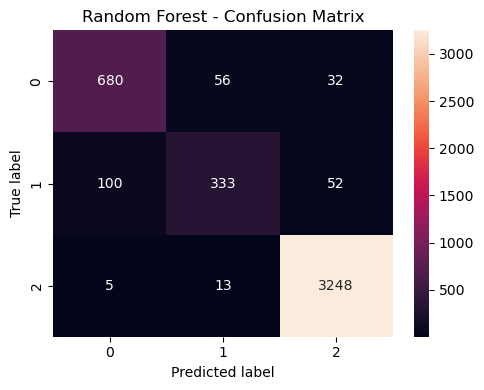

Classification Report
              precision  recall  f1-score
0                 0.866   0.885     0.876
1                 0.828   0.687     0.751
2                 0.975   0.994     0.985
accuracy          0.943   0.943     0.943
macro avg         0.890   0.856     0.870
weighted avg      0.941   0.943     0.941


In [8]:
print("n_estimators: ", best_num_est)

print("Accuracy:", best_acc)
print("F1-macro:", best_f1_macro)

rf_best = RandomForestClassifier(
        n_estimators= 150,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1, 
        random_state=42
    )
rf_best.fit(X_train_processed, y_train)


def evaluate_rf(X, y_true, model):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)

    return acc, f1_macro, cm, report, y_true, y_pred

acc, f1_macro, cm, report, y_true, y_pred = evaluate_rf(X_test, y_test, rf_best)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=[0,1,2],
    yticklabels=[0,1,2]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

print("Classification Report")
df_report = pd.DataFrame(report).T.round(3)
df_report = df_report.drop(columns=["support"], errors="ignore")
print(df_report)

 # (d) Machine Learning Classifier 2 #
The KNN algorithm uses a distance metric and a k value to use the distance to the k nearest points and using their known classification (from the training data) to classify a test point. My intuition on using this method is that many of the traits that cause an exoplanet to be classified as false positive or candidate may be shared with a given test point. 

This algorithm works by computing the distance to the nearest k neighbors using either Manhattan distance (p=1) or Euclidian distance (p=2). Manhattan distance is computed by the absolute value of the distance in each dimension whereas Euclidian distance uses the distance formula to find the shortest distance from point to point. A small value of k tends to overfit the dataset causing high variance and low test accuracy. Conversely, a large value of k will underfit the data and fail to form any meaningful connections, reducing variance but increasing bias. 

Although this classification is simple in concept, pre-processing and parameter choice are very important to the performance of the model. As discussed above, the parameter choice of k is chosen with a sweep over k's between 1-12. Convention states that an odd number of k be used to avoid ties in classification. The next metric of importance is the way distance is calculated. Manhattan distance treats every axis independently while Euclidian distance is better when features are correlated. The choice of the distance metric is crucial to the perforamnce of the model as differnt points may be "closest" based on the chosen distance metric. The last parameter of importance is the weightage of the points, whether or not there is a majority weighting strategy to classify test points or a distance based weighting, where closer neighbors contribute more to the classification. Empirical testing gives us the best parameters as follows:

- k = 3
- p = 1
- weights=distance

Looking at the resulting graph, we can see that Manhattan distance outperformed Euclidian distance at all values of K, resulting in our choice to use p = 1. The test accuracy also peaked at k=3 representing the optimal point in the bias-variance tradeoff where k > 3 introduces too much of a bias leading to underfitting. There were two options to choose from when it came to weighting strategy. Once again, the graph on test accuracy shows that distance weighting outperforms uniform weighting, with the optimal model performance following the chosen parameters.

=== Manhattan Distance (distance weighting) ===
k =  1 | Test Acc = 0.9097
k =  2 | Test Acc = 0.9097
k =  3 | Test Acc = 0.9115
k =  4 | Test Acc = 0.9091
k =  5 | Test Acc = 0.9062
k =  6 | Test Acc = 0.9057
k =  7 | Test Acc = 0.9009
k =  8 | Test Acc = 0.9002
k =  9 | Test Acc = 0.8978
k = 10 | Test Acc = 0.8953
k = 11 | Test Acc = 0.8942

=== Euclidian Distance (distance weighting)===
k =  1 | Test Acc = 0.9077
k =  2 | Test Acc = 0.9077
k =  3 | Test Acc = 0.9037
k =  4 | Test Acc = 0.9020
k =  5 | Test Acc = 0.8947
k =  6 | Test Acc = 0.8953
k =  7 | Test Acc = 0.8947
k =  8 | Test Acc = 0.8940
k =  9 | Test Acc = 0.8911
k = 10 | Test Acc = 0.8909
k = 11 | Test Acc = 0.8885
=== Manhattan Distance (uniform weighting) ===
k =  1 | Test Acc = 0.9097
k =  2 | Test Acc = 0.9104
k =  3 | Test Acc = 0.9095
k =  4 | Test Acc = 0.9095
k =  5 | Test Acc = 0.9042
k =  6 | Test Acc = 0.9035
k =  7 | Test Acc = 0.8973
k =  8 | Test Acc = 0.8971
k =  9 | Test Acc = 0.8887
k = 10 | Test Acc = 

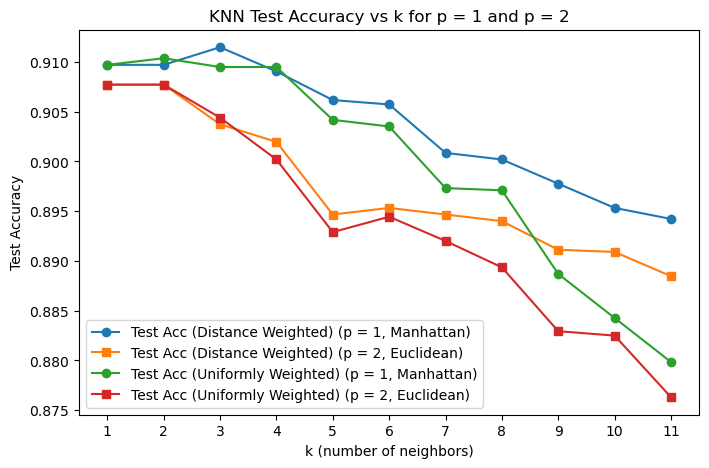

In [9]:
k_values = range(1, 12)

test_acc_p1 = []
test_acc_p2 = []
test_acc_p3 = []
test_acc_p4 = []

print("=== Manhattan Distance (distance weighting) ===")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=1, weights='distance')
    knn.fit(X_train, y_train)
    
    y_test_pred = knn.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_acc_p1.append(test_acc)
    
    print(f"k = {k:2d} | Test Acc = {test_acc:.4f}")

print("\n=== Euclidian Distance (distance weighting)===")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
    knn.fit(X_train, y_train)
    
    y_test_pred = knn.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_acc_p2.append(test_acc)
    
    print(f"k = {k:2d} | Test Acc = {test_acc:.4f}")

print("=== Manhattan Distance (uniform weighting) ===")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=1, weights='uniform')
    knn.fit(X_train, y_train)
    
    y_test_pred = knn.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_acc_p3.append(test_acc)
    
    print(f"k = {k:2d} | Test Acc = {test_acc:.4f}")

print("\n=== Euclidian Distance (uniform weighting) ===")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='uniform')
    knn.fit(X_train, y_train)
    
    y_test_pred = knn.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_acc_p4.append(test_acc)
    
    print(f"k = {k:2d} | Test Acc = {test_acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, test_acc_p1, marker='o', linestyle='-', label='Test Acc (Distance Weighted) (p = 1, Manhattan)')
plt.plot(k_values, test_acc_p2, marker='s', linestyle='-', label='Test Acc (Distance Weighted) (p = 2, Euclidean)')
plt.plot(k_values, test_acc_p3, marker='o', linestyle='-', label='Test Acc (Uniformly Weighted) (p = 1, Manhattan)')
plt.plot(k_values, test_acc_p4, marker='s', linestyle='-', label='Test Acc (Uniformly Weighted) (p = 2, Euclidean)')

plt.xlabel('k (number of neighbors)')
plt.ylabel('Test Accuracy')
plt.title('KNN Test Accuracy vs k for p = 1 and p = 2')
plt.xticks(list(k_values))

plt.legend()
plt.show()


Accuracy: 0.9114848417791547
F1-macro: 0.8146055451221196


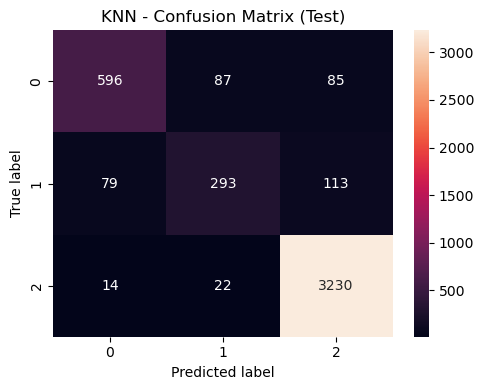

Classification Report
              precision  recall  f1-score
0                 0.865   0.776     0.818
1                 0.729   0.604     0.661
2                 0.942   0.989     0.965
accuracy          0.911   0.911     0.911
macro avg         0.845   0.790     0.815
weighted avg      0.906   0.911     0.907


In [10]:
knn_best = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')
knn_best.fit(X_train, y_train)

def evaluate_knn(model, X, y_true):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)

    return acc, f1_macro, cm, report, y_true, y_pred

acc, f1_macro, cm, report, y_true, y_pred = evaluate_knn(knn_best, X_test, y_test)

print("Accuracy:", acc)
print("F1-macro:", f1_macro)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=[0, 1, 2],
    yticklabels=[0, 1, 2]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("KNN - Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

print("Classification Report")
df_report = pd.DataFrame(report).T.round(3)
df_report = df_report.drop(columns=["support"], errors="ignore")
print(df_report)

# (e) Random Forest Classifier vs K-Nearest Neighbors Classifier #

The Random Forest Classifier (RF) shows superior performance across all performance metrics, achieving a higher accuracy, recall, f1 score and AUC than KNN. The confusion matrices show that KNN has superior performance on Class 0, however RF is able to maintain high recall while maintaining accuracy in the dominant class. KNN performs reasonably well, however not as great as RF. It achieves a high accuracy but shows more misclassifications in class 0 and class 1 which have noticably less samples compared to class 2. This shows that RF better grasps the nonlinear dependencies in the data. 

The ROC curves support this theory as Random Forest achieves an almost perfect curve at 0.995. The KNN ROC is dominated at all stages by RF meaning that in terms of deployment, the RF classifier is the obvious choice. The KNN classifier however, takes less time to train but trades that off with a higher inference latency. 

The confusion matrix at first glance looks very similar as the models have similar values for performance metrics, Random Forest tends to misclassify confirmed exoplanets as candidates whereas KNN misclassifies false positives as candidates. These misclassifications are likely due to similarities between the classes and may be unavoidable in this dataset. 

/opt/homebrew/Caskroom/miniconda/base/envs/ml-systems/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


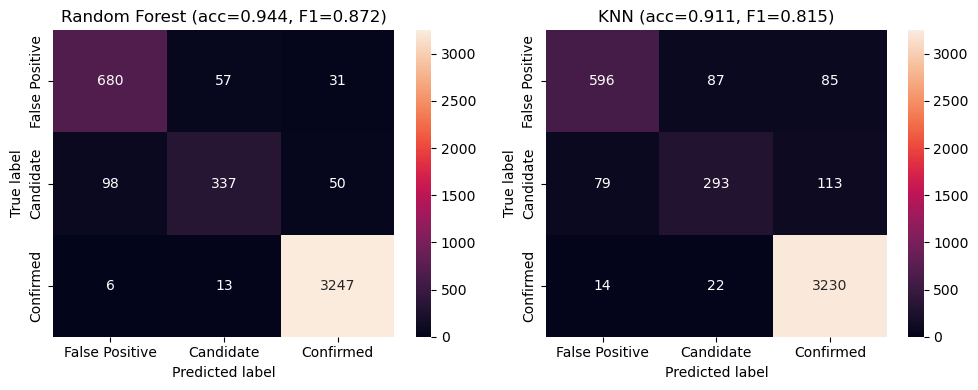

Classification Report (Random Forest)
              precision  recall  f1-score
0                 0.867   0.885     0.876
1                 0.828   0.695     0.756
2                 0.976   0.994     0.985
accuracy          0.944   0.944     0.944
macro avg         0.890   0.858     0.872
weighted avg      0.941   0.944     0.942
Classification Report (KNN)
              precision  recall  f1-score
0                 0.865   0.776     0.818
1                 0.729   0.604     0.661
2                 0.942   0.989     0.965
accuracy          0.911   0.911     0.911
macro avg         0.845   0.790     0.815
weighted avg      0.906   0.911     0.907


In [11]:
acc_knn, f1_knn, cm_knn, report_knn, y_true_knn, y_pred_knn = evaluate_knn(knn_best, X_test, y_test)
acc_rf,  f1_rf,  cm_rf,  report_rf,  y_true_rf,  y_pred_rf  = evaluate_rf(X_test, y_test, rf_clf)


class_names = ["False Positive", "Candidate", "Confirmed"]
vmax = max(cm_knn.max(), cm_rf.max())
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0],
    vmin=0,
    vmax=vmax
)
axes[0].set_title(f"Random Forest (acc={acc_rf:.3f}, F1={f1_rf:.3f})")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")


sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1],
    vmin=0,
    vmax=vmax
)
axes[1].set_title(f"KNN (acc={acc_knn:.3f}, F1={f1_knn:.3f})")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()


print("Classification Report (Random Forest)")
df_report = pd.DataFrame(report_rf).T.round(3)
df_report = df_report.drop(columns=["support"], errors="ignore")
print(df_report)


print("Classification Report (KNN)")
df_report = pd.DataFrame(report_knn).T.round(3)
df_report = df_report.drop(columns=["support"], errors="ignore")
print(df_report)


/opt/homebrew/Caskroom/miniconda/base/envs/ml-systems/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


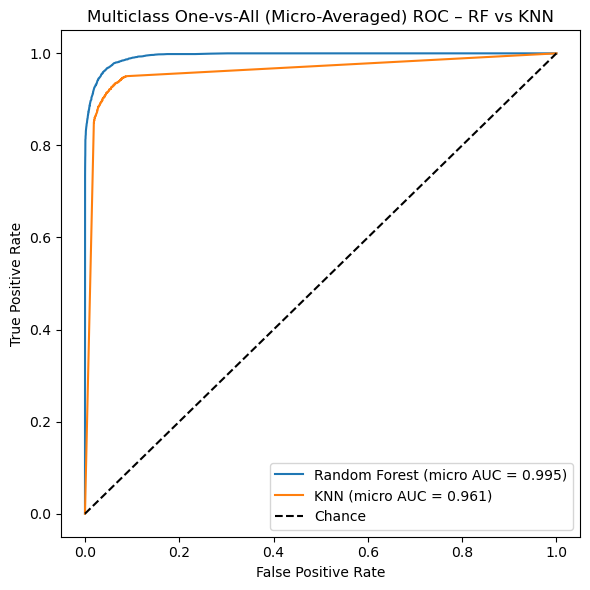

In [12]:

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(6, 6))

for model, name in [(rf_clf, "Random Forest"), (knn_best, "KNN")]:
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{name} (micro AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass One-vs-All (Micro-Averaged) ROC – RF vs KNN")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# (f) Ethical Concerns 

Some potential ethical concerns can be the global impact of satellite imagery/data collection on the environment and the monetary costs associated with it. Additionally, there may be unknown bias on what planets are observed. This dataset in particular is clearly public domain and lacks a lot of personal privacy and race/gender/sexuality discrimination concerns, the main concern is the impact that obtaining the data has on the environment.

# (g) References

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
- https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- https://www.kaggle.com/datasets/chandavandann/nasa-exoplanet-ml-superdataset/data?select=merged_exoplanet_ml_features.csv

I mainly used these resources to understand the algorithm as well as look at the parameters needed to use them